In [3]:
import matplotlib.pyplot as plt
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
from copy import deepcopy
from tqdm.auto import tqdm
from cfg import TrainCfg, TrainCfg_ns, ModelCfg, ModelCfg_ns
from model import ECG_CRNN_CINC2021
from dataset import CINC2021
from torch_ecg.model_configs.cnn import resnet_nature_comm_bottle_neck_se
import seaborn as sns
from gather_results import gather_from_checkpoint, test_inference_speed

from cfg import twelve_leads, six_leads, four_leads, three_leads, two_leads

import time

%load_ext autoreload
%autoreload 2

In [4]:
from scipy.signal import buttord

In [5]:
from matplotlib.pyplot import cm
sns.set()

In [6]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ["+", "v", "x", "*", "p", "d", "s", "$\heartsuit$"]

<IPython.core.display.Javascript object>

In [7]:
marker_size = 9
plt.rcParams['xtick.labelsize']=28
plt.rcParams['ytick.labelsize']=28
plt.rcParams['axes.labelsize']=40
plt.rcParams['legend.fontsize']=24

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# plt.rcParams

## post challenge results

In [1]:
df_pcr = pd.read_csv("./official_results/Post_Challenge_PMEA_test_results.csv")

<IPython.core.display.Javascript object>

In [21]:
df_pcr

,Team Name,Data Source,Lead Combination,Training UID,Test UID,AUROC,AUPRC,Accuracy,F_measure,Challenge Metric,Training Run Time,Hidden Test Run Time
0,Revenger,validation,12,Revenger_32_PMEA,Revenger_32_PMEA_validation_DATASET_1_reruns_1,0.906,0.494,0.455,0.499,0.605,2163m2.499s,5m39.648s
1,Revenger,validation,6,Revenger_32_PMEA,Revenger_32_PMEA_validation_DATASET_2_reruns_1,0.882,0.466,0.419,0.473,0.567,2163m2.499s,5m29.411s
2,Revenger,validation,4,Revenger_32_PMEA,Revenger_32_PMEA_validation_DATASET_3_reruns_1,0.898,0.477,0.437,0.445,0.582,2163m2.499s,5m21.931s
3,Revenger,validation,3,Revenger_32_PMEA,Revenger_32_PMEA_validation_DATASET_4_reruns_1,0.894,0.464,0.421,0.436,0.565,2163m2.499s,5m18.530s
4,Revenger,validation,2,Revenger_32_PMEA,Revenger_32_PMEA_validation_DATASET_5_reruns_1,0.872,0.463,0.428,0.470,0.571,2163m2.499s,5m9.191s
5,Revenger,training,12,Revenger_32_PMEA,Revenger_32_PMEA_training_DATASET_1_reruns_1,0.985,0.911,0.838,0.883,0.925,2163m2.499s,86m0.946s
6,Revenger,training,6,Revenger_32_PMEA,Revenger_32_PMEA_training_DATASET_2_reruns_1,0.975,0.850,0.735,0.812,0.865,2163m2.499s,81m0.209s
7,Revenger,training,4,Revenger_32_PMEA,Revenger_32_PMEA_training_DATASET_3_reruns_1,0.983,0.901,0.815,0.868,0.908,2163m2.499s,76m56.944s
8,Revenger,training,3,Revenger_32_PMEA,Revenger_32_PMEA_training_DATASET_4_reruns_1,0.982,0.903,0.823,0.871,0.912,2163m2.499s,75m28.862s
9,Revenger,training,2,Revenger_32_PMEA,Revenger_32_PMEA_training_DATASET_5_reruns_1,0.974,0.857,0.771,0.814,0.873,2163m2.499s,76m4.080s


In [23]:
sources = ["Total Test", "training", "validation", "CPSC2", "G12EC", "UMich", "Undisclosed",]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

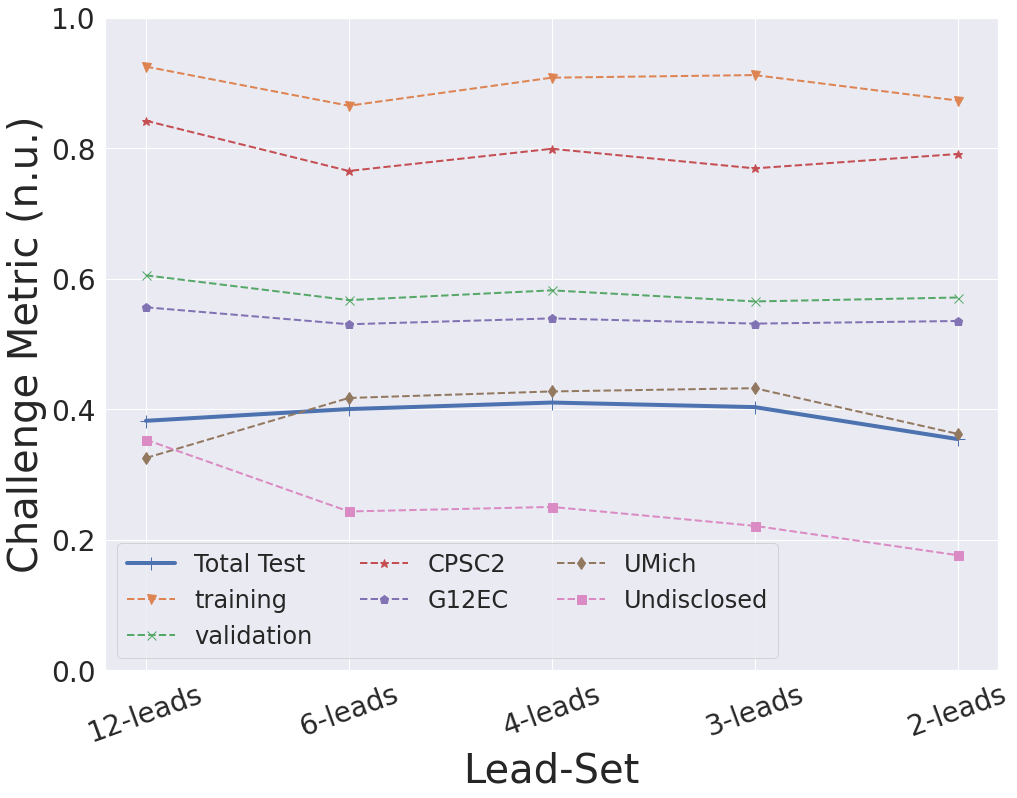

In [35]:
fig, ax = plt.subplots(figsize=(16,12))
# for idx, (source, df_s) in enumerate(df_pcr.groupby("Data Source")):
for idx, source in enumerate(sources):
    df_s = df_pcr[df_pcr["Data Source"]==source]
    df_s = df_s.sort_values("Lead Combination", ascending=False).reset_index(drop=True)
    if idx > 0:
        ls = "--"
        markersize = marker_size
        linewidth = 2
    else:
        ls = "-"
        markersize = marker_size + 4
        linewidth = 4
    ax.plot(
        df_s["Challenge Metric"],
        c=colors[idx],
        marker=markers[idx],
        markersize=markersize,
        label=source,
        ls=ls,
        linewidth=linewidth,
    )
ax.set_ylim(0,1)
ax.set_xlabel("Lead-Set")
ax.set_xticks(np.arange(5))
ax.set_xticklabels([f"{l}-leads" for l in [12,6,4,3,2]], rotation=20)
ax.tick_params(axis = 'both')
ax.set_ylabel("Challenge Metric (n.u.)")
ax.legend(loc="best", ncol=3)

plt.savefig("./images/post-challenge.svg", dpi=1200, bbox_inches="tight", transparent=False)
plt.savefig("./images/post-challenge.pdf", dpi=1200, bbox_inches="tight", transparent=False)

# pre-load datasets

In [ ]:
# ds_val = CINC2021(TrainCfg_ns, training=False, lazy=False)

In [9]:
ds_train = CINC2021(TrainCfg_ns, training=True, lazy=True)

log file path is set /home/wenhao/Jupyter/wenhao/workspace/cinc2021/working_dir/CinC2021-CinC2021.log
levels of c_handler and f_handler are set DEBUG
converting dtypes of columns `diagnosis` and `diagnosis_scored`...

start performing train test split...

train test split finished in 0.02 minutes


In [10]:
# ds_train._load_all_data()

In [11]:
ECG_CRNN_CINC2021.__DEBUG__ = False

In [ ]:
from torch_ecg.utils.misc import dict_to_str, get_record_list_recursive3

In [ ]:
from gather_results import append_model_config_if_needed

In [ ]:
from gather_results import gather_from_checkpoint
from dataset import CINC2021

%load_ext autoreload
%autoreload 2

In [ ]:
from torch_ecg.utils.misc import MovingAverage

In [ ]:
ma = MovingAverage()

In [ ]:
append_model_config_if_needed()

# gather statistics

In [ ]:
results_dir = os.path.join(os.path.dirname(TrainCfg.log_dir), "results")
results_dir

In [ ]:
l_csv = [
    os.path.join(results_dir,item+".csv") \
    for item in get_record_list_recursive3("/home/wenhao/Jupyter/wenhao/workspace/cinc2021/results/", "TorchECG.*\.csv")
]

In [ ]:
eval_models = True

In [ ]:
res = {}
# with tqdm(l_csv) as t:
for fp in t:
    df_fp = pd.read_csv(fp)
    zs = ""
    ls = ""
    lr = "-adaptive"
    loss = "-bce"
    mixup = ""
    cnn_name = ""
    rnn_name = ""
    attn_name = ""
    bp = ""
    with open(fp.replace("csv", "txt"), "r") as txt:
        lines = txt.read().splitlines()[-1000:]
    model_fp = None
    for l in lines:
        tmp = re.findall("/.*BestModel.*\.pth\.tar", l)
        if len(tmp) > 0:
            model_fp = tmp[0]
    if model_fp is None:
        print(f"{fp} has no corr. model")
        continue
    model, train_cfg = ECG_CRNN_CINC2021.from_checkpoint(model_fp)
    
    print("model loaded from checkpoint")
    
    if "normalize" in train_cfg:
        zs = "-zscore"
    if "mixup" in train_cfg:
        mixup = "-mixup"
    if "label_smooth" in train_cfg and train_cfg["label_smooth"]:
        ls = "-label_smooth"
    if train_cfg["loss"] == "AsymmetricLoss":
        loss = "-asymmetric"
    if train_cfg["lr_scheduler"] in ["one_cycle", "onecycle"]:
        lr = "-onecycle"
    if train_cfg["bandpass"] is None:
        bp = "-no_bp"
    cnn_name = model.config.cnn.name
    if model.config.rnn.name != "none":
        rnn_name = "-"+model.config.rnn.name
    if model.config.attn.name != "none":
        attn_name = "-"+model.config.attn.name
    n_linear = len([m for m in model.clf if m.__class__.__name__=='Linear'])
    clf = f"-{n_linear}linear"
    name = f"{cnn_name}{rnn_name}{attn_name}{clf}{zs}{ls}{mixup}{loss}{lr}{bp}"

    train_loss = df_fp[df_fp.part=="train"][["epoch", "step", "loss", "time"]].dropna()
    train_cm = df_fp[df_fp.part=="train"][["epoch", "step", "challenge_metric"]].dropna()
    val_cm = df_fp[df_fp.part=="val"][["epoch", "step", "challenge_metric"]].dropna()

    time_used = []
    for ep, df_gp in train_loss.groupby("epoch"):
        time_used.append(np.diff(pd.to_datetime(df_gp["time"]).values))
    time_used = np.concatenate(time_used)/np.timedelta64(1, 's')
    
    print("stats gathered")
    
    time.sleep(5)

    if eval_models:
        if len(train_cfg.leads) < 12:
            ds_use = CINC2021.from_extern(ds_train, train_cfg)
        else:
            ds_use = ds_train
            
        time.sleep(5)

        inf_speed = test_inference_speed(model_fp, ds_use)
    else:
        inf_speed = np.nan

    time.sleep(5)
        
    print("inference speed computed")

    res[fp] = {
        "folder": list(filter(lambda s: len(s)>0, os.path.dirname(fp).split(os.path.sep)))[-1],
        "name": name,
        "cnn_name": model.config.cnn.name,
        "rnn_name": model.config.rnn.name,
        "attn_name": model.config.attn.name,
        "n_linear": n_linear,
        "n_leads": len(train_cfg.leads),
        "train_loss": train_loss,
        "train_cm": train_cm,
        "val_cm": val_cm,
        "size": model.module_size,
        "size_h": model.module_size_,
        "val_cm_max": val_cm.challenge_metric.max(),
        "speed": round((64*20/time_used).mean()),
        "inf_speed": inf_speed,
    }
    del model
    if eval_models:
        if ds_use is not ds_train:
            del ds_use
        torch.cuda.empty_cache()
    print(f"{name} finished")
    print("#"*80 + "\n"*2)

In [ ]:
len(res)

In [ ]:
df_res = pd.DataFrame(res.values())

In [ ]:
df_res.name.values

In [ ]:
df_res["efficiency"] = df_res["val_cm_max"] / df_res["size"] * 1e8
df_res["val_cm_max"] = df_res["val_cm_max"].apply(lambda s: round(s,4))
df_res["size"] = df_res["size"].apply(lambda s: round(s/1000000, 2))
df_res["efficiency"] = df_res["efficiency"].apply(lambda s: round(s,3))

In [ ]:
df_res = df_res.sort_values("val_cm_max", ascending=False).reset_index(drop=True)

In [ ]:
df_res

# 5 sets of ablation studies

In [ ]:
df_aba_1 = df_res[df_res.name.str.startswith("resnet_nature_comm_se-lstm-se-2linear") & (df_res.n_leads==12)].reset_index(drop=True)
# df_aba_1 = df_aba_1.sort_values("val_cm_max")

In [ ]:
df_aba_1

In [ ]:
df_aba_1.name.tolist()

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
for idx, row in df_aba_1.iterrows():
    train_loss = row.train_loss
    train_cm = row.train_cm
    val_cm = row.val_cm
    if "bce" in row["name"]:
        ax.plot([])
        continue
    label = row["name"].replace("resnet_nature_comm_se-lstm-se-2linear-", "")
    ax.plot(
        (train_loss.index.values*20)[::18], (ma(train_loss.loss, weight=0.6))[::18],
        label=label,
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
ax.set_xlabel("Steps (n.u.)")
ax.set_ylabel("Loss (n.u.)")
ax.tick_params(axis = 'y', rotation = 45)
ax.set_ylim(0,0.2)
ax.legend(loc="upper right")

fig.tight_layout()

plt.savefig("./images/abla1_loss.svg", dpi=1200, bbox_inches="tight", transparent=False)
plt.savefig("./images/abla1_loss.pdf", dpi=1200, bbox_inches="tight", transparent=False)

In [ ]:
fig, ax = plt.subplots(figsize=(16,16))
belt1, belt2 = [], []
for idx, row in df_aba_1.iterrows():
    train_cm = row.train_cm
    label = row["name"].replace("resnet_nature_comm_se-lstm-se-2linear-", "train-")
    ax.plot(
        train_cm.index.values*20, train_cm.challenge_metric,
        label=label,
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
    if "bce" not in row["name"]:
        belt1.append(train_cm.challenge_metric.values)
belt1 = np.array(belt1)
for idx, row in df_aba_1.iterrows():
    val_cm = row.val_cm
    label = row["name"].replace("resnet_nature_comm_se-lstm-se-2linear-", "val-")
    ax.plot(
        val_cm.index.values*20, val_cm.challenge_metric,
        ls='--',
        label=label,
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
    if "bce" not in row["name"]:
        belt2.append(val_cm.challenge_metric.values)
belt2 = np.array(belt2)
ax.fill_between(train_cm.index.values*20, np.mean(belt1,axis=0)-0.06, np.mean(belt1,axis=0)+0.06, color='r', alpha=.15)
ax.fill_between(train_cm.index.values*20, np.mean(belt2,axis=0)-0.028, np.mean(belt2,axis=0)+0.028, color='g', alpha=.2)
ax.set_xlabel("Steps (n.u.)")
ax.set_ylabel("Challenge Metric (n.u.)")
ax.set_ylim(0.23,0.97)
ax.legend(loc="lower right", fontsize=20)

fig.tight_layout()

plt.savefig("./images/abla1_cm.pdf", dpi=1200, bbox_inches="tight")
plt.savefig("./images/abla1_cm.svg", dpi=1200, bbox_inches="tight")

In [ ]:
abla_2 = [
 'resnet_nature_comm_se-lstm-se-2linear-zscore-mixup-asymmetric-onecycle',
 'resnet_nature_comm_se-se-2linear-zscore-mixup-asymmetric-onecycle',
 'resnet_nature_comm_se-2linear-zscore-mixup-asymmetric-onecycle',
 'resnet_nature_comm_se-1linear-zscore-mixup-asymmetric-onecycle'
]

In [ ]:
df_abla2 = df_res[(df_res.name.isin(abla_2)) & (df_res.n_leads==12)].reset_index(drop=True)

In [ ]:
df_abla2

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
belt1, belt2 = np.full((len(abla_2),50), np.nan), np.full((len(abla_2),50), np.nan)
for idx, row in df_abla2.iterrows():
    train_cm = row.train_cm
    ax.plot(
        train_cm.index.values*20, train_cm.challenge_metric,
        label=row["name"].replace("resnet_nature_comm_se-", "train-").replace("-zscore-mixup-asymmetric-onecycle", ""),
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
    belt1[idx,:len(train_cm.challenge_metric)] = train_cm.challenge_metric.values
for idx, row in df_abla2.iterrows():
    val_cm = row.val_cm
    ax.plot(
        val_cm.index.values*20, val_cm.challenge_metric,
        ls='--',
        label=row["name"].replace("resnet_nature_comm_se-", "val-").replace("-zscore-mixup-asymmetric-onecycle", ""),
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
    belt2[idx,:len(val_cm.challenge_metric)] = val_cm.challenge_metric.values
ax.fill_between(train_cm.index.values*20, np.nanmean(belt1,axis=0)-0.06, np.nanmean(belt1,axis=0)+0.06, color='r', alpha=.15)
ax.fill_between(train_cm.index.values*20, np.nanmean(belt2,axis=0)-0.032, np.nanmean(belt2,axis=0)+0.026, color='g', alpha=.2)
ax.set_xlabel("Steps (n.u.)")
ax.set_ylabel("Challenge Metric (n.u.)")
ax.legend(loc="lower right")
ax.set_ylim(0.25,1)

fig.tight_layout()

plt.savefig("./images/abla2_cm.pdf", dpi=1200, bbox_inches="tight")
plt.savefig("./images/abla2_cm.svg", dpi=1200, bbox_inches="tight")

In [ ]:
abla_3 = ['resnet_nature_comm_se-lstm-se-2linear-zscore-mixup-asymmetric-onecycle',
 'resnet_nature_comm_bottle_neck_se-lstm-se-2linear-zscore-mixup-asymmetric-onecycle',
 'tresnetN-lstm-se-2linear-zscore-mixup-asymmetric-onecycle',
 'tresnetP-lstm-se-2linear-zscore-mixup-asymmetric-onecycle',
 'tresnetF-lstm-se-2linear-zscore-mixup-asymmetric-onecycle',
 'multi_scopic-lstm-se-2linear-zscore-mixup-asymmetric-onecycle',
 'multi_scopic_leadwise-lstm-se-2linear-zscore-mixup-asymmetric-onecycle',]

In [ ]:
df_abla3 = df_res[(df_res.name.isin(abla_3)) & (df_res.n_leads==12) & (~df_res.folder.str.contains("1127|nas"))].reset_index(drop=True)

df_abla3["ordering"] = df_abla3.name.apply(lambda s: abla_3.index(s))
df_abla3 = df_abla3.sort_values(by="ordering").reset_index(drop=True)

In [ ]:
df_abla3

In [ ]:
name_map = {
    "resnet_nature_comm_se": "ResNet_NC_SE",
    "resnet_nature_comm_bottle_neck_gc": "ResNet_NC_BG",
    "multi_scopic": "branched",
    "multi_scopic_leadwise": "branched_leadwise",
    "resnet_nature_comm_bottle_neck_se": "ResNet_NC_BS",
    "tresnetN": "TResNet-N",
    "tresnetP": "TResNet-P",
    "tresnetF": "TResNet-F",
}

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
belt1, belt2 = np.full((len(abla_3),50), np.nan), np.full((len(abla_3),50), np.nan)
for idx, row in df_abla3.iterrows():
    train_cm = row.train_cm
    if len(train_cm) == 50:
        _train_cm = train_cm
    name = row["name"].replace("-lstm-se-2linear-zscore-mixup-asymmetric-onecycle", "")
    ax.plot(
        train_cm.index.values*20, train_cm.challenge_metric,
        label="train-"+name_map.get(name,name),
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
    belt1[idx,:len(train_cm.challenge_metric)] = train_cm.challenge_metric.values
for idx, row in df_abla3.iterrows():
    val_cm = row.val_cm
    name = row["name"].replace("-lstm-se-2linear-zscore-mixup-asymmetric-onecycle", "")
    ax.plot(
        val_cm.index.values*20, val_cm.challenge_metric,
        ls='--',
        label="val-"+name_map.get(name,name),
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
    belt2[idx,:len(val_cm.challenge_metric)] = val_cm.challenge_metric.values
ax.fill_between(_train_cm.index.values*20, np.nanmean(belt1,axis=0)-0.06, np.nanmean(belt1,axis=0)+0.06, color='r', alpha=.15)
ax.fill_between(_train_cm.index.values*20, np.nanmean(belt2,axis=0)-0.03, np.nanmean(belt2,axis=0)+0.028, color='g', alpha=.2)
ax.set_xlabel("Steps (n.u.)")
ax.set_ylabel("Challenge Metric (n.u.)")
ax.legend(loc="lower right", ncol=2)
ax.set_ylim(0.23,1)

fig.tight_layout()

plt.savefig("./images/abla3_cm.pdf", dpi=1200, bbox_inches="tight")
plt.savefig("./images/abla3_cm.svg", dpi=1200, bbox_inches="tight")

In [ ]:
df_abla3

In [ ]:
df_abla3.at[1,"val_cm"].challenge_metric.max()

In [ ]:
df_abla3.at[6,"val_cm"].challenge_metric.max()

In [ ]:
for idx, row in df_abla3.iterrows():
    print(row["name"], df_abla3.at[idx,"val_cm"].challenge_metric.max())

In [ ]:
abla_4 = [
 'resnet_nature_comm_se-1linear-zscore-mixup-asymmetric-onecycle',
 'resnet_nature_comm_bottle_neck_se-1linear-zscore-mixup-asymmetric-onecycle',
 'tresnetN-1linear-zscore-mixup-asymmetric-onecycle',
 'tresnetP-1linear-zscore-mixup-asymmetric-onecycle',
 'tresnetF-1linear-zscore-mixup-asymmetric-onecycle',
 'multi_scopic-1linear-zscore-mixup-asymmetric-onecycle',
 'multi_scopic_leadwise-1linear-zscore-mixup-asymmetric-onecycle',
]

In [ ]:
df_abla4 = df_res[(df_res.name.isin(abla_4)) & (df_res.n_leads==12) & (~df_res.folder.str.contains("nas"))].reset_index(drop=True)
df_abla4["ordering"] = df_abla4.name.apply(lambda s: abla_4.index(s))
df_abla4 = df_abla4.sort_values(by="ordering").reset_index(drop=True)

In [ ]:
df_abla4

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
belt1, belt2 = np.full((len(abla_4),50), np.nan), np.full((len(abla_4),50), np.nan)
_train_cm = pd.DataFrame()
for idx, row in df_abla4.iterrows():
    train_cm = row.train_cm
    if len(train_cm) > len(_train_cm):
        _train_cm = train_cm
    name = row["name"].replace("-1linear-zscore-mixup-asymmetric-onecycle", "")
    ax.plot(
        train_cm.index.values*20, train_cm.challenge_metric,
        label="train-"+name_map.get(name,name),
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
    belt1[idx,:len(train_cm.challenge_metric)] = train_cm.challenge_metric.values
belt1 = belt1[...,:len(_train_cm)]
belt2 = belt2[...,:len(_train_cm)]
for idx, row in df_abla4.iterrows():
    val_cm = row.val_cm
    name = row["name"].replace("-1linear-zscore-mixup-asymmetric-onecycle", "")
    ax.plot(
        val_cm.index.values*20, val_cm.challenge_metric,
        ls='--',
        label="val-"+name_map.get(name,name),
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
    belt2[idx,:len(val_cm.challenge_metric)] = val_cm.challenge_metric.values
ax.set_xlabel("Steps (n.u.)")
ax.set_ylabel("Challenge Metric (n.u.)")
ax.legend(loc="lower right", ncol=2)
ax.set_ylim(0.26,1.01)

fig.tight_layout()

plt.savefig("./images/abla4_cm.pdf", dpi=1200, bbox_inches="tight")
plt.savefig("./images/abla4_cm.svg", dpi=1200, bbox_inches="tight")

In [ ]:
# abla5 leads 12-2, resnet-nc-se, lstm, se, 2-linear, asymmetric loss, one cycle 1e-4 to 2e-3

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
df_abla5 = df_res[(df_res.n_leads<12) | (df_res.name == 'resnet_nature_comm_se-lstm-se-2linear-zscore-mixup-asymmetric-onecycle')].reset_index(drop=True)

In [ ]:
df_abla5 = df_abla5.sort_values("n_leads", ascending=False).reset_index(drop=True)

In [ ]:
df_abla5

In [ ]:
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset, InsetPosition

max_cm = {}

fig, ax = plt.subplots(figsize=(16,12))
belt1, belt2 = np.full((len(df_abla5),50), np.nan), np.full((len(df_abla5),50), np.nan)
_train_cm = pd.DataFrame()
for idx, row in df_abla5.iterrows():
    train_cm = row.train_cm
    if len(train_cm) > len(_train_cm):
        _train_cm = train_cm
    ax.plot(
        train_cm.index.values*20, train_cm.challenge_metric,
        label=f"train-{row.n_leads}-leads",
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
    belt1[idx,:len(train_cm.challenge_metric)] = train_cm.challenge_metric.values
for idx, row in df_abla5.iterrows():
    val_cm = row.val_cm
    name = row["name"].replace("-1linear-zscore-mixup-asymmetric-onecycle", "")
    ax.plot(
        val_cm.index.values*20, val_cm.challenge_metric,
        ls='--',
        label=f"val-{row.n_leads}-leads",
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
    max_cm[row.n_leads] = val_cm.challenge_metric.max()
    belt2[idx,:len(val_cm.challenge_metric)] = val_cm.challenge_metric.values
ax.fill_between(_train_cm.index.values*20, np.nanmean(belt1,axis=0)-0.042, np.nanmean(belt1,axis=0)+0.042, color='r', alpha=.15)
ax.fill_between(_train_cm.index.values*20, np.nanmean(belt2,axis=0)-0.03, np.nanmean(belt2,axis=0)+0.03, color='g', alpha=.2)
ax.set_xlabel("Steps (n.u.)")
ax.set_ylabel("Challenge Metric (n.u.)")
ax.legend(loc="upper left", ncol=2)
ax.set_ylim(0.2,1.05)

rect = patches.Rectangle((42000, 0.62), 14200, 0.08, facecolor="none", edgecolor="black", ls="-", lw=3)
ax.add_patch(rect)

axin = inset_axes(
    ax, width="35%", height="30%",
    loc=4, borderpad=3,
)
axin.plot([max_cm[l] for l in df_abla5.n_leads.values], color="black", marker="o", markersize=8)
axin.set_ylim(0.62,0.72)
axin.set_xlabel("Lead-Set", fontsize=22)
axin.set_xticks(np.arange(len(df_abla5.n_leads.values)))
axin.set_xticklabels([f"{l}-leads" for l in df_abla5.n_leads.values])
axin.tick_params(axis = 'both', labelsize = 16)
axin.set_ylabel("Challenge Metric (n.u.)", fontsize=22)
axin.grid()
# axin.tick_params(axis = 'y', rotation = 45)
axin.plot((2), max_cm[4], marker='o', markersize=10, color='r', )
axin.plot((3), max_cm[3], marker='o', markersize=10, color='r', )
for idx, l in enumerate(df_abla5.n_leads.values):
    c = "black" if idx not in [2,3] else "red"
    axin.text(idx-0.2, max_cm[l]+0.004, f"{max_cm[l]:.3f}", fontsize=18, color=c)

rect = patches.Rectangle((28800, 0.22), 27200, 0.335, facecolor="none", edgecolor="black", ls="-", lw=3)
ax.add_patch(rect)

ax.annotate('', xytext=(49000, 0.62), xy=(46000, 0.552), 
            arrowprops=dict(facecolor='black', shrink=0.06),)

fig.tight_layout()

plt.savefig("./images/abla5_cm.pdf", dpi=1200, bbox_inches="tight")
plt.savefig("./images/abla5_cm.svg", dpi=1200, bbox_inches="tight")

## new ablation (NAS) result

In [ ]:
df_new_abla = df_res[df_res.folder.str.contains("nas")].reset_index(drop=True)
df_new_abla["name"] = df_new_abla["name"].apply(lambda s: s.replace("resnet_nature_comm_bottle_neck_se-", "").replace("-zscore-label_smooth-mixup-asymmetric-onecycle", ""))
df_new_abla = df_new_abla.sort_values("val_cm_max", ascending=False).reset_index(drop=True)
df_new_abla = df_new_abla.drop(["folder", "n_leads"], axis=1)

In [ ]:
df_new_abla

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
belt1, belt2 = np.full((len(df_new_abla),50), np.nan), np.full((len(df_new_abla),50), np.nan)
_train_cm = pd.DataFrame()
for idx, row in df_new_abla.iterrows():
    train_cm = row.train_cm
    if len(train_cm) > len(_train_cm):
        _train_cm = train_cm
    name = row["name"].replace("-zscore-mixup-asymmetric-onecycle", "")
    ax.plot(
        train_cm.index.values*20, train_cm.challenge_metric,
        label="train-"+name_map.get(name,name),
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
    belt1[idx,:len(train_cm.challenge_metric)] = train_cm.challenge_metric.values
belt1 = belt1[...,:len(_train_cm)]
belt2 = belt2[...,:len(_train_cm)]
for idx, row in df_new_abla.iterrows():
    val_cm = row.val_cm
    name = row["name"].replace("-zscore-mixup-asymmetric-onecycle", "")
    ax.plot(
        val_cm.index.values*20, val_cm.challenge_metric,
        ls='--',
        label="val-"+name_map.get(name,name),
        c=colors[idx],
        marker=markers[idx],
        markersize=marker_size,
    )
    belt2[idx,:len(val_cm.challenge_metric)] = val_cm.challenge_metric.values
ax.fill_between(_train_cm.index.values*20, np.nanmean(belt1,axis=0)-0.06, np.nanmean(belt1,axis=0)+0.06, color='r', alpha=.15)
ax.fill_between(_train_cm.index.values*20, np.nanmean(belt2,axis=0)-0.02, np.nanmean(belt2,axis=0)+0.02, color='g', alpha=.2)
ax.set_xlabel("Steps (n.u.)")
ax.set_ylabel("Challenge Metric (n.u.)")
ax.legend(loc="lower right", ncol=2)
ax.set_ylim(0.23,1)

fig.tight_layout()

plt.savefig("./images/abla6_cm.pdf", dpi=1200, bbox_inches="tight")
plt.savefig("./images/abla6_cm.svg", dpi=1200, bbox_inches="tight")

In [ ]:
df_compare = df_res[(df_res.n_leads==12)&(df_res.rnn_name=="none")&(df_res.attn_name=="none")&(df_res.n_linear==1)&(df_res.name.str.endswith("-zscore-mixup-asymmetric-onecycle"))].reset_index(drop=True)

In [ ]:
df_compare

In [ ]:
df_compare = df_compare.iloc[[0,1,3,4,5,6,7,8]].reset_index(drop=True)

In [ ]:
df_compare = df_compare.sort_values("size",ascending=True).reset_index(drop=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
# ax.set_xscale("log")
df_tmp = df_compare[df_compare.cnn_name.str.startswith("resnet_nature")]
ax.plot(df_tmp["size"], df_tmp.val_cm_max, c=colors[0])
for _, row in df_tmp.iterrows():
    ax.plot(row["size"], row.val_cm_max, marker='o', markersize=18, c=colors[0])
    if row.cnn_name == "resnet_nature_comm_se":
        x,y = row["size"]+0.2, row.val_cm_max-0.001
    elif row.cnn_name == "resnet_nature_comm_bottle_neck_se":
        x,y = row["size"]-0.9, row.val_cm_max+0.002
    elif row.cnn_name == "resnet_nature_comm_bottle_neck_gc":
        x,y = row["size"]+0.2, row.val_cm_max-0.002
    ax.text(x,y, name_map[row.cnn_name],c=colors[0], fontsize=21 )
df_tmp = df_compare[df_compare.cnn_name.str.startswith("tresnet")]
ax.plot(df_tmp["size"], df_tmp.val_cm_max, c=colors[1])
for _, row in df_tmp.iterrows():
    ax.plot(row["size"], row.val_cm_max, marker='o', markersize=18, c=colors[1])
    if row.cnn_name == "tresnetN":
        x,y = row["size"]-1.2, row.val_cm_max+0.0025
    else:
        x,y = row["size"]+0.3, row.val_cm_max-0.003
    ax.text(x,y, name_map[row.cnn_name],c=colors[1], fontsize=21 )
df_tmp = df_compare[df_compare.cnn_name.str.startswith("multi")]
ax.plot(df_tmp["size"], df_tmp.val_cm_max, c=colors[2])
for _, row in df_tmp.iterrows():
    ax.plot(row["size"], row.val_cm_max, marker='o', markersize=18, c=colors[2])
    if row.cnn_name == "multi_scopic":
        x,y = row["size"]-0.4, row.val_cm_max-0.006
    else:
        x,y = row["size"]-0.9, row.val_cm_max+0.003
    ax.text(x,y, name_map[row.cnn_name],c=colors[2], fontsize=21 )
ax.set_ylim(0.62, 0.73)
ax.set_xlabel("# Params (million)")
ax.set_ylabel("Challenge Metric (n.u.)")


fig.tight_layout()

plt.savefig("./images/nn_compare.pdf", dpi=1200, bbox_inches="tight")
plt.savefig("./images/nn_compare.svg", dpi=1200, bbox_inches="tight")

In [ ]:
train_config = deepcopy(TrainCfg_ns)
train_config.rnn_name = "lstm"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_config.n_leads = len(train_config.leads)

tranches = train_config.tranches_for_training
if tranches:
    classes = train_config.tranche_classes[tranches]
else:
    classes = train_config.classes

if train_config.n_leads == 12:
    model_config = deepcopy(ModelCfg_ns.twelve_leads)
elif train_config.n_leads == 6:
    model_config = deepcopy(ModelCfg_ns.six_leads)
elif train_config.n_leads == 4:
    model_config = deepcopy(ModelCfg_ns.four_leads)
elif train_config.n_leads == 3:
    model_config = deepcopy(ModelCfg_ns.three_leads)
elif train_config.n_leads == 2:
    model_config = deepcopy(ModelCfg_ns.two_leads)
model_config.cnn.name = train_config.cnn_name
model_config.rnn.name = train_config.rnn_name
model_config.attn.name = train_config.attn_name

In [ ]:
l_cnn = [
    "resnet_nature_comm_se",
    "resnet_nature_comm_bottle_neck_se",
    "tresnetN",
    "tresnetP",
    "tresnetF",
    "multi_scopic",
    "multi_scopic_leadwise",
]

In [ ]:
ms = {}

for name in l_cnn:
    model_config.cnn.name = name
    model = ECG_CRNN_CINC2021(
        classes=train_config.classes,
        n_leads=train_config.n_leads,
        config=model_config,
    )
    ms[name] = model.cnn.module_size

In [ ]:
df_table = df_res[df_res.name.str.contains("-zscore-mixup-asymmetric-onecycle")][["name", "n_leads", "size", "size_h", "val_cm_max", "speed", "inf_speed", "efficiency"]].reset_index(drop=True)

In [ ]:
df_table.name = df_table.name.apply(lambda s: s.replace("-zscore-mixup-asymmetric-onecycle", ""))

In [ ]:
df_table[df_table.name.str.startswith("resnet_nature_comm_se")].reset_index(drop=True)

## special detectors

In [1]:
import json, gzip

In [2]:
with gzip.open("./results/special_detector_test_results_xqrs.json.gz", "r") as f:
    content = json.load(f)

In [3]:
cm_sd = ED()

<IPython.core.display.Javascript object>

In [4]:
for c in ["LAD", "RAD", "PR", "LQRSV"]:
    cm_sd[c] = ED()
    cm_sd[c].tp = 0
    cm_sd[c].fp = 0
    cm_sd[c].fn = 0
    cm_sd[c].tn = 0
    for item in content["twelve_leads"]:
        if c in item["label"]:
            if c in item["pred"]:
                cm_sd[c].tp += 1
            else:
                cm_sd[c].fn += 1
        else:
            if c in item["pred"]:
                cm_sd[c].fp += 1
            else:
                cm_sd[c].tn += 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
c = "brady"
cm_sd[c] = ED()
cm_sd[c].tp = 0
cm_sd[c].fp = 0
cm_sd[c].fn = 0
cm_sd[c].tn = 0
for item in content["twelve_leads"]:
    if "Brady" in item["label"] or "SB" in item["label"]:
        if c in item["pred"]:
            cm_sd[c].tp += 1
        else:
            cm_sd[c].fn += 1
    else:
        if c in item["pred"]:
            cm_sd[c].fp += 1
        else:
            cm_sd[c].tn += 1

<IPython.core.display.Javascript object>

In [6]:
cm_sd

{'LAD': {'tp': 6547, 'fp': 13547, 'fn': 1084, 'tn': 57778},
 'RAD': {'tp': 927, 'fp': 3723, 'fn': 353, 'tn': 73953},
 'PR': {'tp': 671, 'fp': 55, 'fn': 809, 'tn': 77421},
 'LQRSV': {'tp': 787, 'fp': 2798, 'fn': 700, 'tn': 74671},
 'brady': {'tp': 18905, 'fp': 5342, 'fn': 306, 'tn': 54403}}

In [12]:
[item for item in content["twelve_leads"] if "LAD" in item["pred"]]

[{'rec': 'A0018',
  'label': ['CLBBB'],
  'pred': ['brady', 'LAD'],
  'err': 'False'},
 {'rec': 'A0023', 'label': ['AF'], 'pred': ['tachy', 'LAD'], 'err': 'False'},
 {'rec': 'A0038', 'label': ['NSR'], 'pred': ['LAD'], 'err': 'False'},
 {'rec': 'A0041', 'label': ['NSR'], 'pred': ['LAD'], 'err': 'False'},
 {'rec': 'A0064', 'label': ['AF'], 'pred': ['tachy', 'LAD'], 'err': 'False'},
 {'rec': 'A0078', 'label': ['CRBBB'], 'pred': ['LAD'], 'err': 'False'},
 {'rec': 'A0081',
  'label': ['CLBBB'],
  'pred': ['tachy', 'LAD'],
  'err': 'False'},
 {'rec': 'A0083',
  'label': ['CRBBB'],
  'pred': ['tachy', 'LAD'],
  'err': 'False'},
 {'rec': 'A0087', 'label': ['CRBBB'], 'pred': ['LAD'], 'err': 'False'},
 {'rec': 'A0089', 'label': ['NSR'], 'pred': ['LAD'], 'err': 'False'},
 {'rec': 'A0095',
  'label': ['CRBBB'],
  'pred': ['brady', 'LAD', 'LQRSV'],
  'err': 'False'},
 {'rec': 'A0113', 'label': ['PAC'], 'pred': ['LAD'], 'err': 'False'},
 {'rec': 'A0117', 'label': ['AF'], 'pred': ['LAD'], 'err': 'Fal

In [19]:
ds_train.reader.get_labels()

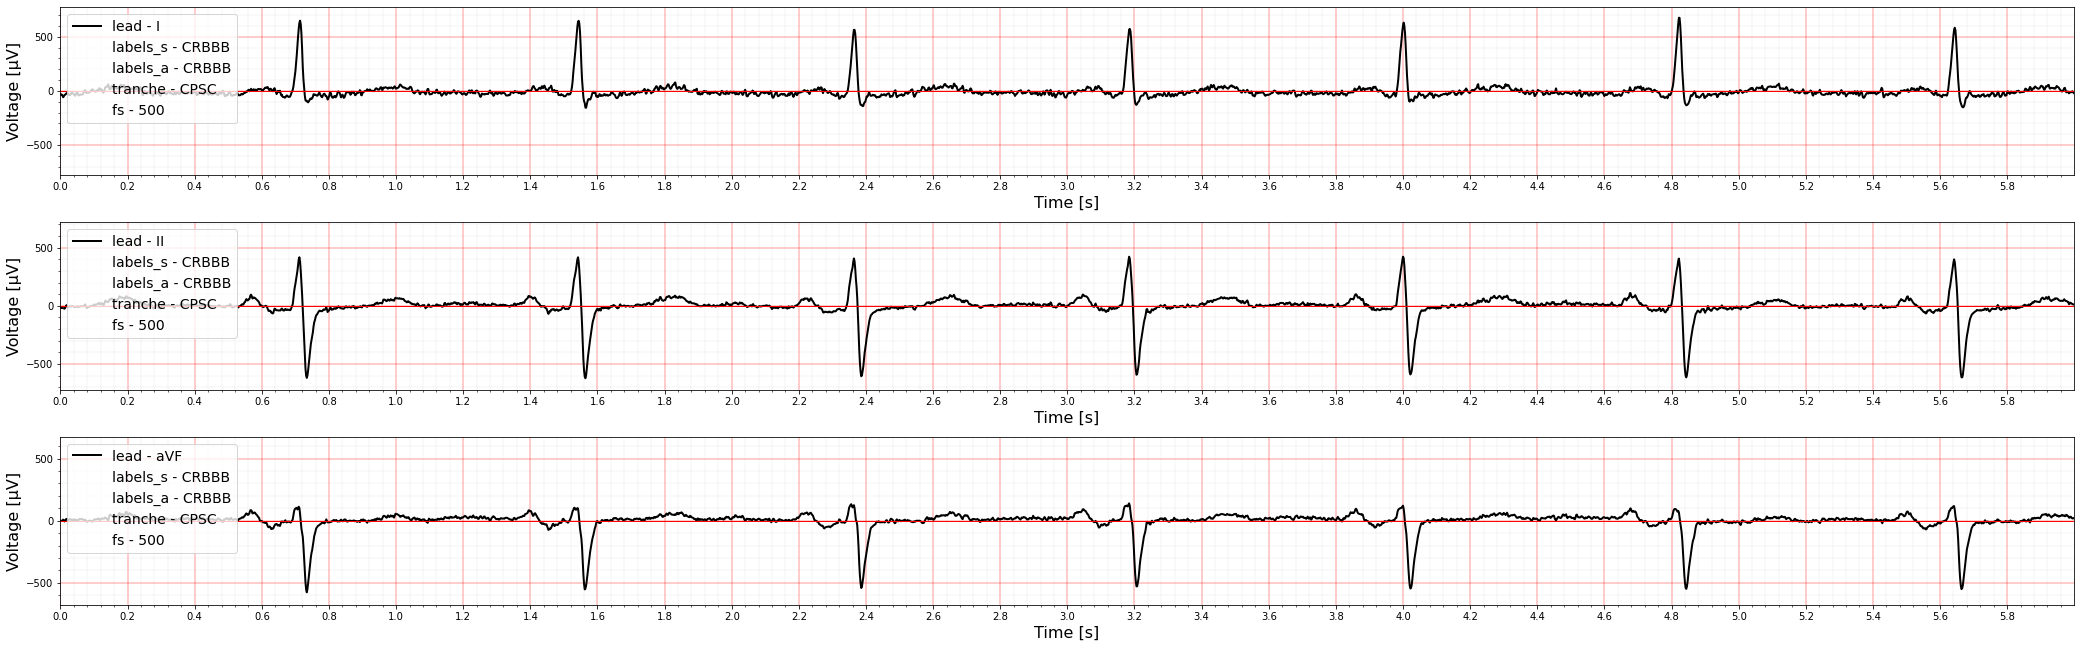

In [45]:
ds_train.reader.plot(
    "A0226",
#     leads=["I", "II", "III", "aVR", "aVL", "aVF",],
    leads = ["I", "II", "aVF",],
    ticks_granularity=2,
    save_path="./working_dir/A0226.pdf"
)

In [38]:
np.ones((12,))

<IPython.core.display.Javascript object>

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [39]:
np.maximum(0.5, np.ones((12,)))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
df_res

In [ ]:
df_sota = df_res[(df_res.cnn_name.str.contains("resnet_nature_comm_bottle_neck")) & (df_res.n_leads==12)].reset_index(drop=True)

In [ ]:
df_sota.name.tolist()

In [ ]:
df_sota